In [60]:
import geopandas
import pandas as pd
import os
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt

# Data Collection

In [59]:
data_folder = "./data/raw/"
data_files = { 
    "fire_dz": "viirs-jpss1_2024_Algeria.csv",
    "fire_tn": "viirs-jpss1_2024_Tunisia.csv",
    "landcover_dz": "landcover_dz/dza_gc_adg.shp",
    "landcover_tn": "landcover_tn/tun_gc_adg.shp", # updated the file
    "climate_prec": "wc2.1_cruts4.09_5m_prec_2020-2024",
    "climate_tmax": "wc2.1_cruts4.09_5m_tmax_2020-2024",
    "climate_tmin": "wc2.1_cruts4.09_5m_tmin_2020-2024",
    "elevation": "be15_grd/be15_grd",
    "dz_boundaries": "gadm41_DZA_shp/gadm41_DZA_0.shp",
    "tn_boundaries": "gadm41_TUN_shp/gadm41_TUN_0.shp",
    "soil": "HWSD2_RASTER/HWSD2.bil"
}

output_folder = "./processed_data"
output_folders = {
    "fire": "fire_dataset",
    "landcover": "landcover_dataset",
    "climate": "climate_dataset",
    "elevation": "elevation_dataset",
    "soil": "soil_dataset"
}

## Fire Dataset

Downloaded from: https://firms.modaps.eosdis.nasa.gov/country/

https://www.earthdata.nasa.gov/data/instruments/viirs/viirs-i-band-375-m-active-fire-data

Attribute	Short Description	Long Description

Latitude	Latitude	Center of nominal 375 m fire pixel

Longitude	Longitude	Center of nominal 375 m fire pixel

Bright_ti4	Brightness temperature I-4	VIIRS I-4 channel brightness temperature of the fire pixel measured in Kelvin

Scan	Along Scan pixel size	The algorithm produces approximately 375 m pixels at nadir. Scan and track reflect actual pixel size

Track	Along Track pixel size	The algorithm produces approximately 375 m pixels at nadir. Scan and track reflect actual pixel size

Acq_Date	Acquisition Date	Date of VIIRS acquisition

Acq_Time	Acquisition Time	Time of acquisition/overpass of the satellite (in UTC)

Satellite	Satellite	N= Suomi National Polar-orbiting Partnership (Suomi NPP), N20=NOAA-20 (designated JPSS-1 prior to launch), N21=NOAA-21 (designated JPSS-2 prior to launch)

Confidence	Confidence	

This value is based on a collection of intermediate algorithm quantities used in the detection process. It is intended to help users gauge the quality of individual hotspot/fire pixels. Confidence values are set to low, nominal and high. Low confidence daytime fire pixels are typically associated with areas of sun glint and lower relative temperature anomaly (<15K) in the mid-infrared channel I4. Nominal confidence pixels are those free of potential sun glint contamination during the day and marked by strong (>15K) temperature anomaly in either day or nighttime data. High confidence fire pixels are associated with day or nighttime saturated pixels.

Please note: Low confidence nighttime pixels occur only over the geographic area extending from 11deg E to 110 deg W and 7 deg N to 55 deg S. This area describes the region of influence of the South Atlantic Magnetic Anomaly which can cause spurious brightness temperatures in the mid-infrared channel I4 leading to potential false positive alarms. These have been removed from the NRT data distributed by FIRMS.
Version	Version (Collection and source)	Version identifies the collection (e.g. VIIRS Collection 1) and source of data processing: Near Real-Time (NRT suffix added to collection) or Standard Processing (collection only)
"1.0NRT" - Collection 1 NRT processing
"1.0" - Collection 1 Standard processing

Bright_ti5	Brightness temperature I-5	I-5 Channel brightness temperature of the fire pixel measured in Kelvin

FRP	Fire Radiative Power	FRP depicts the pixel-integrated fire radiative power in MW (megawatts). FRP depicts the pixel-integrated fire radiative power in MW (megawatts). Given the unique spatial and spectral resolution of the data, the VIIRS 375 m fire detection algorithm was customized and tuned in order to optimize its response over small fires while balancing the occurrence of false alarms. Frequent saturation of the mid-infrared I4 channel (3.55-3.93 µm) driving the detection of active fires requires additional tests and procedures to avoid pixel classification errors. As a result, sub-pixel fire characterization (e.g., fire radiative power [FRP] retrieval) is only viable across small and/or low-intensity fires. Systematic FRP retrievals are based on a hybrid approach combining 375 and 750 m data. In fact, starting in 2015 the algorithm incorporated additional VIIRS channel M13 (3.973-4.128 µm) 750 m data in both aggregated and unaggregated format.

DayNight	Day or Night	D= Daytime fire, N= Nighttime fire

### Merging Algeria & Tunisia

In [42]:
# Loading the DZ data
fire_dz_filepath = os.path.join(data_folder, data_files["fire_dz"])
fire_dz_df = pd.read_csv(fire_dz_filepath, parse_dates=[['acq_date', 'acq_time']])
fire_dz_df

/tmp/ipykernel_11527/1591558197.py:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  fire_dz_df = pd.read_csv(fire_dz_filepath, parse_dates=[['acq_date', 'acq_time']])


acq_date_acq_time  latitude  longitude  bright_ti4  scan  track  \
0     2024-01-01 00:03:00  27.72818    9.87200      295.51  0.76   0.77   
1     2024-01-01 00:03:00  28.63288    9.77909      301.80  0.79   0.78   
2     2024-01-01 00:03:00  28.64012    9.77953      298.65  0.79   0.78   
3     2024-01-01 01:41:00  36.74886    6.25409      338.04  0.46   0.39   
4     2024-01-01 01:41:00  35.87978    4.44782      309.49  0.41   0.37   
...                   ...       ...        ...         ...   ...    ...   
87441 2024-12-31 13:31:00  34.86016   -1.37439      337.17  0.43   0.46   
87442 2024-12-31 13:31:00  35.80756   -0.34148      326.23  0.50   0.49   
87443 2024-12-31 13:31:00  36.74493    6.25849      334.95  0.60   0.71   
87444 2024-12-31 13:31:00  36.86816    6.98849      331.50  0.66   0.73   
87445 2024-12-31 13:32:00  36.86970    6.98770      332.72  0.66   0.73   

      satellite instrument confidence  version  bright_ti5   frp daynight  \
0           N20      VIIRS          n        2      277.66  1.24        N   
1           N20      VIIRS          n        2      277.05  1.57        N   
2           N20      VIIRS          n        2      277.04  1.34        N   
3           N20      VIIRS          n        2      257.28  5.21        N   
4           N20      VIIRS          n        2      272.08  1.58        N   
...         ...        ...        ...      ...         ...   ...      ...   
87441       N20      VIIRS          n        2      287.63  3.18        D   
87442       N20      VIIRS          n        2      282.76  3.58        D   
87443       N20      VIIRS          n        2      286.65  4.28        D   
87444       N20      VIIRS          n        2      285.38  4.55        D   
87445       N20      VIIRS          n        2      284.90  5.24        D   

       type  
0         2  
1         2  
2         2  
3         2  
4         2  
...     ...  
87441     0  
87442     2  
87443     2  
87444     2  
87445     2  

[87446 rows x 14 columns]

In [45]:
# Loading the TN data
fire_tn_filepath = os.path.join(data_folder, data_files["fire_tn"])
fire_tn_df = pd.read_csv(fire_tn_filepath, parse_dates=[['acq_date', 'acq_time']])
fire_tn_df

/tmp/ipykernel_11527/1977834866.py:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  fire_tn_df = pd.read_csv(fire_tn_filepath, parse_dates=[['acq_date', 'acq_time']])


acq_date_acq_time  latitude  longitude  bright_ti4  scan  track  \
0    2024-01-01 01:42:00  31.64847    9.16945      315.79  0.53   0.50   
1    2024-01-01 01:42:00  31.49290    9.48947      302.32  0.56   0.51   
2    2024-01-01 01:42:00  31.49524    9.49053      301.88  0.56   0.51   
3    2024-01-01 01:42:00  33.36728    8.54768      302.58  0.45   0.47   
4    2024-01-02 01:24:00  31.64812    9.17107      320.80  0.46   0.39   
...                  ...       ...        ...         ...   ...    ...   
2799 2024-12-30 00:50:00  31.65023    9.17049      308.73  0.50   0.41   
2800 2024-12-31 00:31:00  31.64881    9.17031      323.63  0.61   0.53   
2801 2024-12-31 00:31:00  31.65072    9.16963      320.75  0.61   0.53   
2802 2024-12-31 02:10:00  36.59308   10.31617      296.55  0.63   0.72   
2803 2024-12-31 02:12:00  31.64872    9.17024      309.77  0.74   0.76   

     satellite instrument confidence  version  bright_ti5   frp daynight  type  
0          N20      VIIRS          n        2      279.09  2.20        N     2  
1          N20      VIIRS          n        2      276.10  1.23        N     0  
2          N20      VIIRS          n        2      276.12  0.77        N     0  
3          N20      VIIRS          n        2      277.15  0.80        N     2  
4          N20      VIIRS          n        2      278.37  2.44        N     2  
...        ...        ...        ...      ...         ...   ...      ...   ...  
2799       N20      VIIRS          n        2      278.50  1.21        N     2  
2800       N20      VIIRS          n        2      279.46  2.57        N     2  
2801       N20      VIIRS          n        2      279.13  3.50        N     2  
2802       N20      VIIRS          n        2      278.94  1.12        N     2  
2803       N20      VIIRS          n        2      278.10  2.16        N     2  

[2804 rows x 14 columns]

In [46]:
# We add a country column 
fire_dz_df["country"] = "DZ"
fire_tn_df["country"] = "TN"

# Vertical concatenation
fire_df = pd.concat([fire_dz_df, fire_tn_df])

fire_df.head()

acq_date_acq_time  latitude  longitude  bright_ti4  scan  track satellite  \
0 2024-01-01 00:03:00  27.72818    9.87200      295.51  0.76   0.77       N20   
1 2024-01-01 00:03:00  28.63288    9.77909      301.80  0.79   0.78       N20   
2 2024-01-01 00:03:00  28.64012    9.77953      298.65  0.79   0.78       N20   
3 2024-01-01 01:41:00  36.74886    6.25409      338.04  0.46   0.39       N20   
4 2024-01-01 01:41:00  35.87978    4.44782      309.49  0.41   0.37       N20   

  instrument confidence  version  bright_ti5   frp daynight  type country  
0      VIIRS          n        2      277.66  1.24        N     2      DZ  
1      VIIRS          n        2      277.05  1.57        N     2      DZ  
2      VIIRS          n        2      277.04  1.34        N     2      DZ  
3      VIIRS          n        2      257.28  5.21        N     2      DZ  
4      VIIRS          n        2      272.08  1.58        N     2      DZ

### EDA

In [47]:
fire_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90250 entries, 0 to 2803
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   acq_date_acq_time  90250 non-null  datetime64[ns]
 1   latitude           90250 non-null  float64       
 2   longitude          90250 non-null  float64       
 3   bright_ti4         90250 non-null  float64       
 4   scan               90250 non-null  float64       
 5   track              90250 non-null  float64       
 6   satellite          90250 non-null  object        
 7   instrument         90250 non-null  object        
 8   confidence         90250 non-null  object        
 9   version            90250 non-null  int64         
 10  bright_ti5         90250 non-null  float64       
 11  frp                90250 non-null  float64       
 12  daynight           90250 non-null  object        
 13  type               90250 non-null  int64         
 14  country     

#### Missing values

In [48]:
fire_df.isna().sum()

acq_date_acq_time    0
latitude             0
longitude            0
bright_ti4           0
scan                 0
track                0
satellite            0
instrument           0
confidence           0
version              0
bright_ti5           0
frp                  0
daynight             0
type                 0
country              0
dtype: int64

#### Non-variable variables

In [49]:
fire_df['version'].value_counts()

version
2    90250
Name: count, dtype: int64

In [50]:
fire_df['instrument'].value_counts()

instrument
VIIRS    90250
Name: count, dtype: int64

In [51]:
fire_df['satellite'].value_counts()

satellite
N20    90250
Name: count, dtype: int64

#### Categorical variables

What is the confidence?

In [52]:
fire_df['confidence'].value_counts()

confidence
n    84128
l     5013
h     1109
Name: count, dtype: int64

In [ ]:
fire_df['type'].value_counts()
# what is the type attribute?

type
2    75495
0    14216
3      539
Name: count, dtype: int64

In [28]:
fire_df['daynight'].value_counts()

daynight
N    68979
D    21271
Name: count, dtype: int64

In [35]:
numerical_features = ['bright_ti4', 'scan', 'track', 'bright_ti5', 'frp']
categorical_features = ['daynight', 'type', 'confidence']

In [18]:
fire_df.describe()

latitude     longitude    bright_ti4          scan         track  \
count  90250.000000  90250.000000  90250.000000  90250.000000  90250.000000   
mean      31.476760      6.280033    321.091793      0.475991      0.515446   
std        2.666477      2.593748     18.205551      0.101596      0.126508   
min       19.603230     -8.118050    240.170000      0.320000      0.360000   
25%       28.911510      5.642160    305.380000      0.400000      0.390000   
50%       31.409125      6.557880    316.710000      0.450000      0.490000   
75%       32.560313      8.083758    337.400000      0.540000      0.620000   
max       37.323460     11.110350    367.000000      0.800000      0.780000   

           acq_time  version    bright_ti5           frp          type  
count  90250.000000  90250.0  90250.000000  90250.000000  90250.000000  
mean     380.331623      2.0    291.726092      3.447776      1.690936  
std      480.710563      0.0     11.700269      5.222111      0.735207  
min        0.000000      2.0    244.790000      0.060000      0.000000  
25%       59.000000      2.0    282.900000      1.150000      2.000000  
50%      140.000000      2.0    290.790000      2.060000      2.000000  
75%      232.000000      2.0    298.100000      3.920000      2.000000  
max     1410.000000      2.0    355.420000    251.890000      3.000000

#### Visualizations

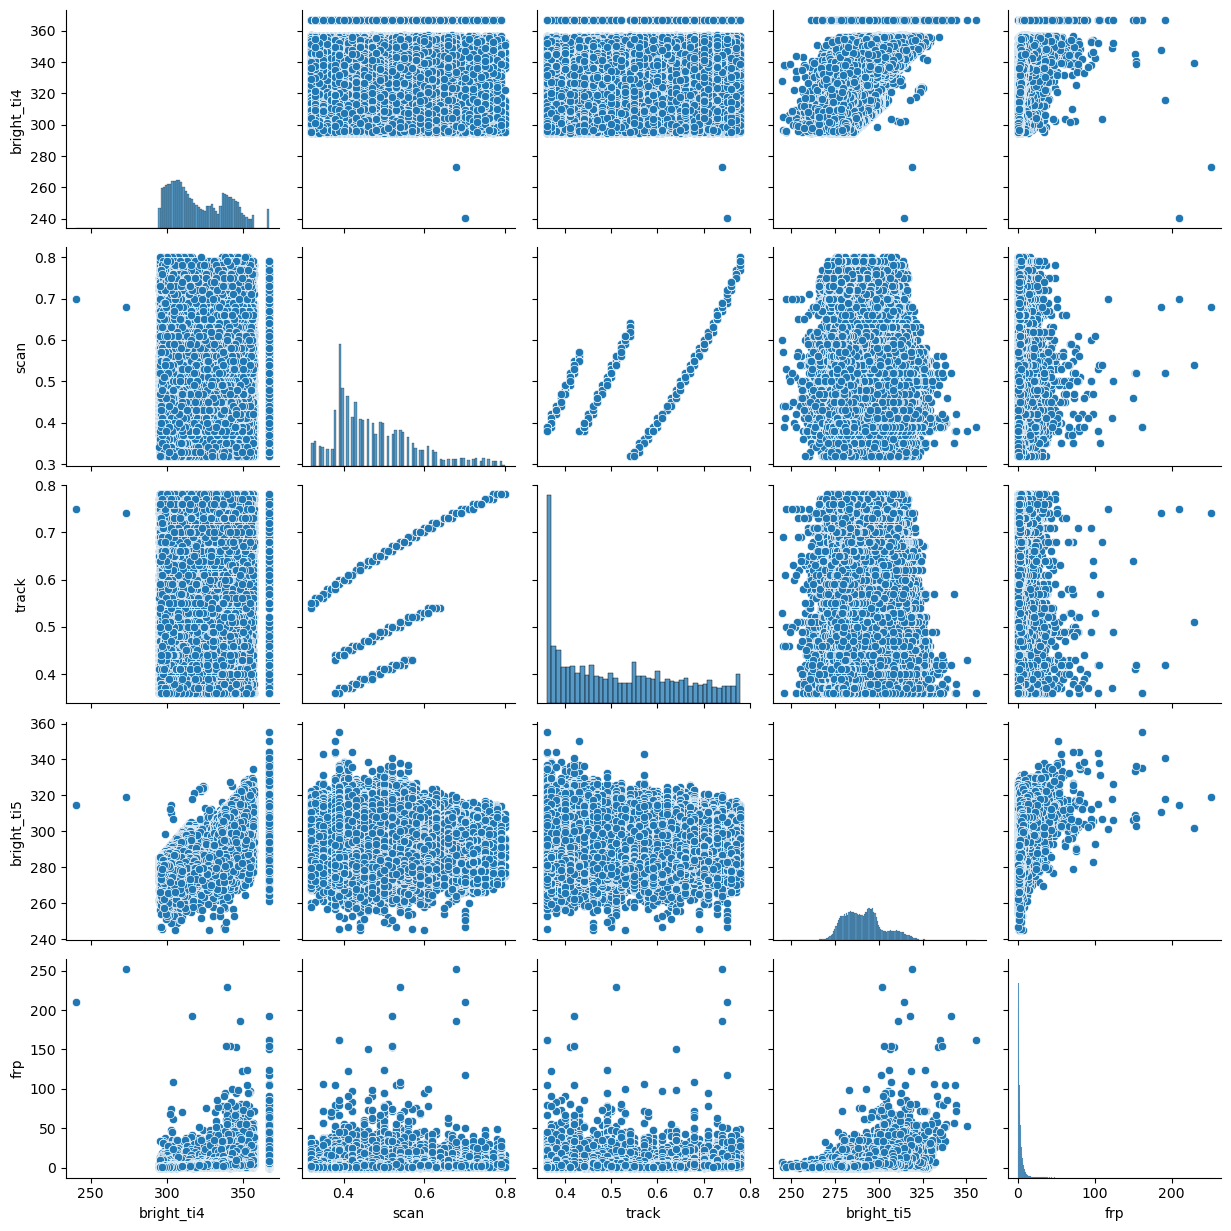

In [54]:
import seaborn as sns

sns.pairplot(fire_df[numerical_features])

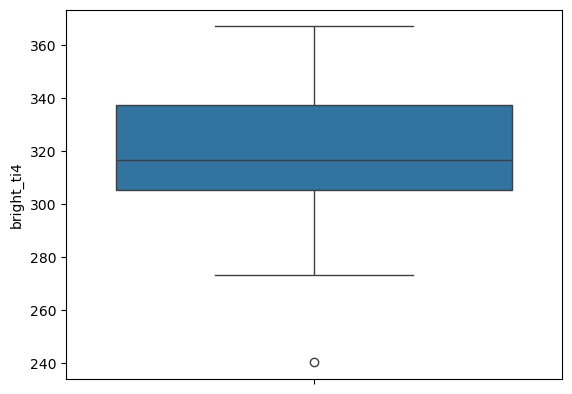

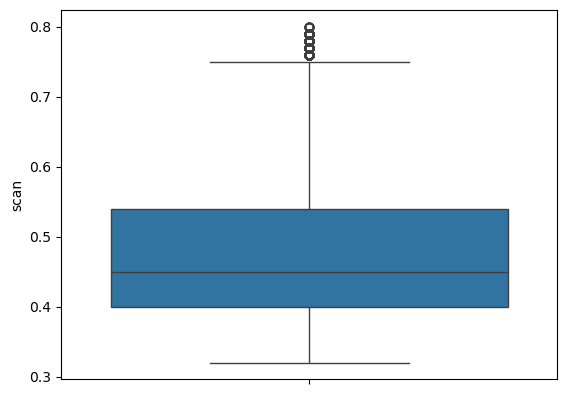

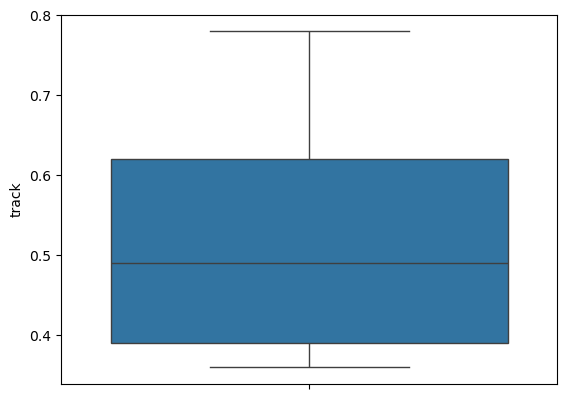

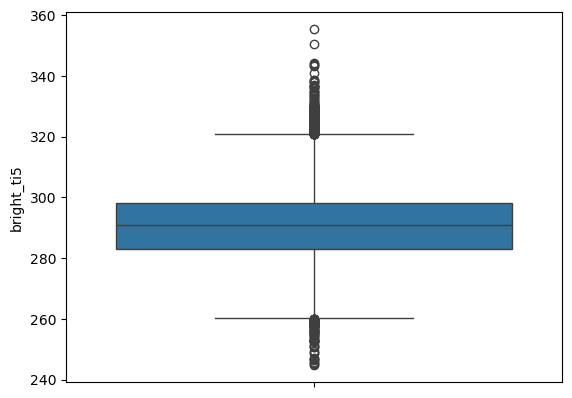

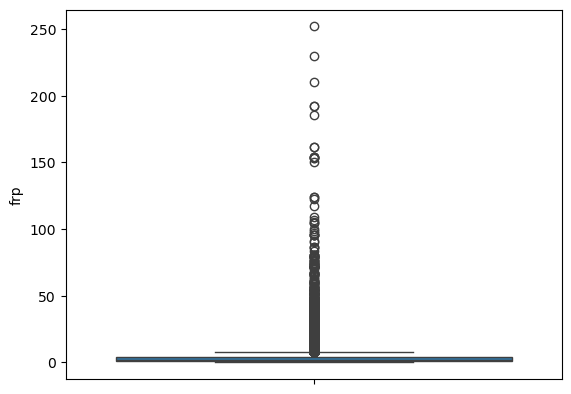

In [55]:
for feature in numerical_features:
    sns.boxplot(fire_df, y=feature)
    plt.show()

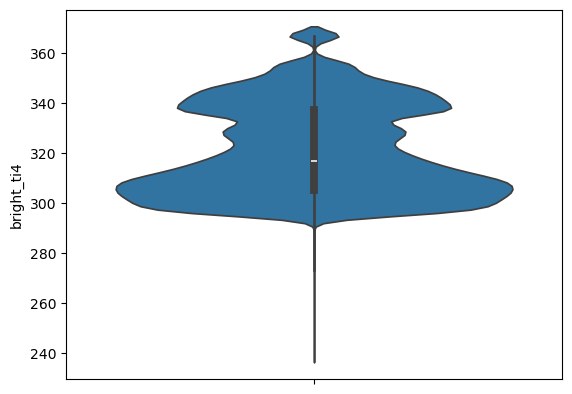

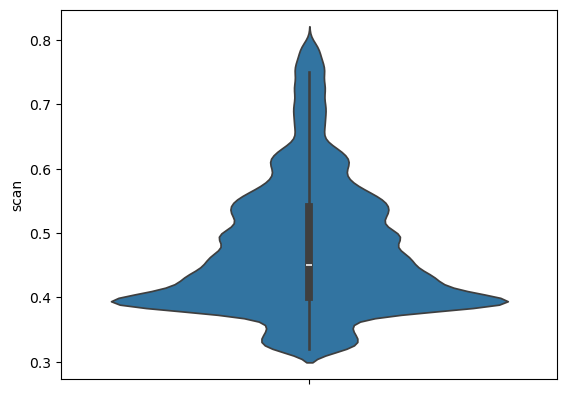

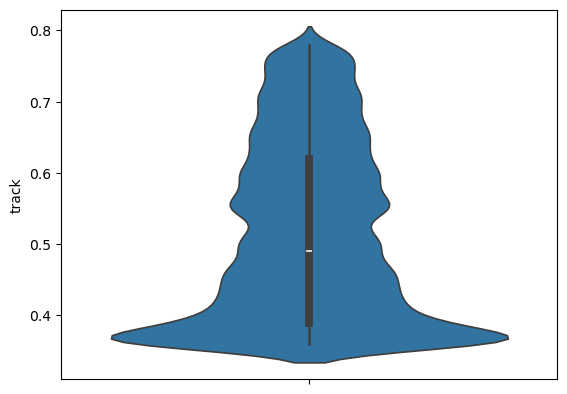

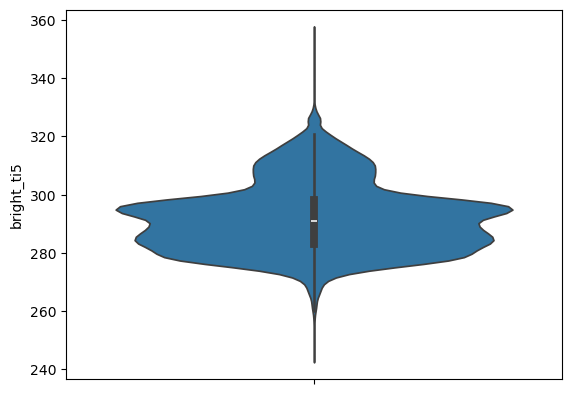

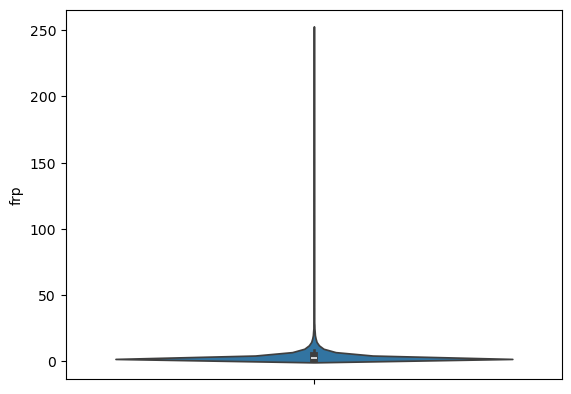

In [63]:
for feature in numerical_features:
    sns.violinplot(fire_df, y=feature)
    plt.show()

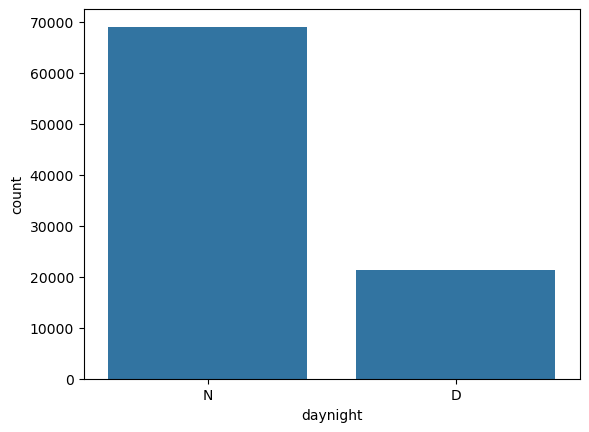

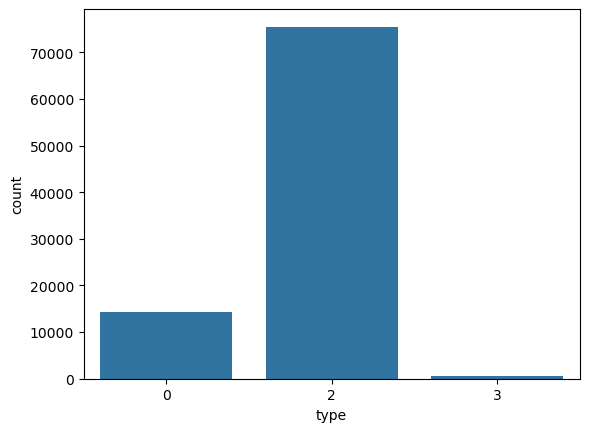

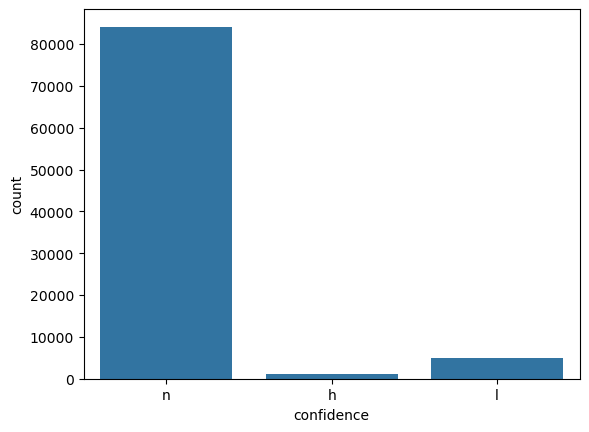

In [57]:
for feature in categorical_features:
    sns.countplot(fire_df, x=feature)
    plt.show()

Text(0.5, 1.0, 'Fire type')

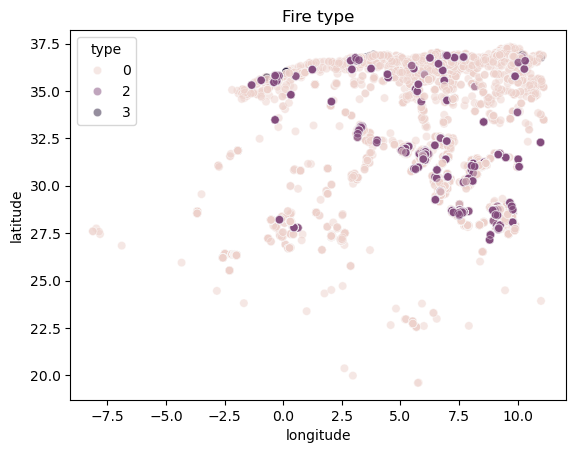

In [68]:
sns.scatterplot(fire_df, x='longitude', y='latitude', hue='type', alpha=0.5)
plt.title('Fire type')

Text(0.5, 1.0, 'Fire frp')

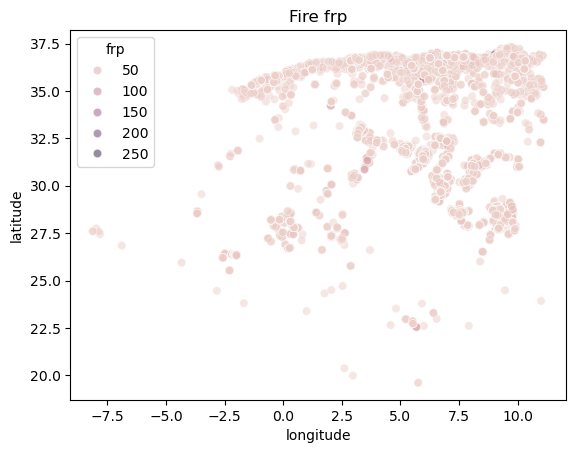

In [69]:
sns.scatterplot(fire_df, x='longitude', y='latitude', hue='frp', alpha=0.5)
plt.title('Fire frp')

Text(0.5, 1.0, 'Fire bright ti4')

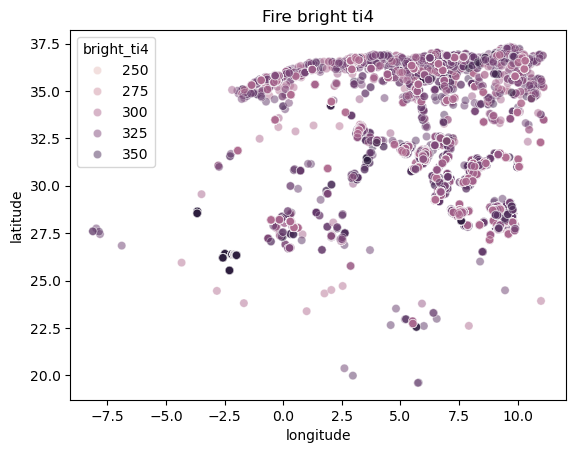

In [70]:
sns.scatterplot(fire_df, x='longitude', y='latitude', hue='bright_ti4', alpha=0.5)
plt.title('Fire bright ti4')

Text(0.5, 1.0, 'Fire bright ti5')

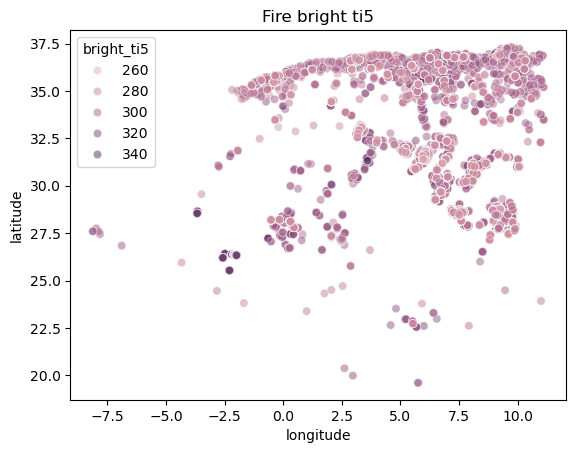

In [71]:
sns.scatterplot(fire_df, x='longitude', y='latitude', hue='bright_ti5', alpha=0.5)
plt.title('Fire bright ti5')

<Axes: xlabel='frp', ylabel='Density'>

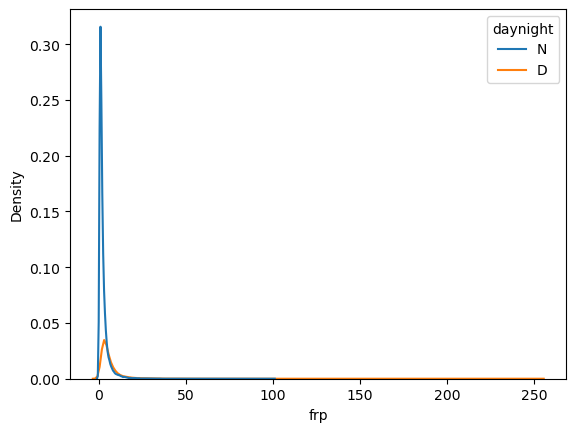

In [75]:
sns.kdeplot(fire_df, x='frp', hue='daynight')

<Axes: xlabel='acq_date_acq_time', ylabel='frp'>

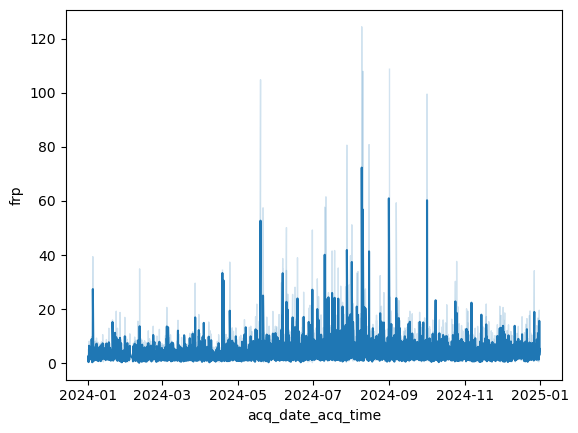

In [79]:
sns.lineplot(fire_df, x='acq_date_acq_time', y='frp')

<Axes: xlabel='acq_date_acq_time', ylabel='bright_ti4'>

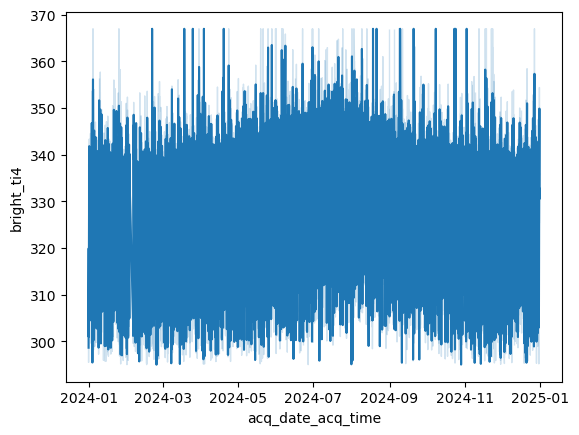

In [91]:
sns.lineplot(fire_df, x='acq_date_acq_time', y='bright_ti4')

<Axes: xlabel='acq_date_acq_time', ylabel='bright_ti5'>

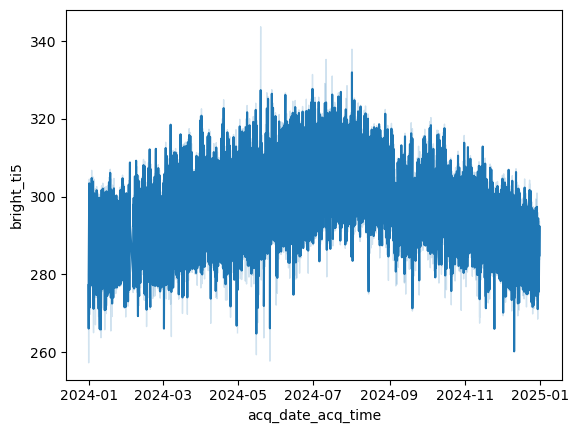

In [92]:
sns.lineplot(fire_df, x='acq_date_acq_time', y='bright_ti5')

<Axes: xlabel='confidence', ylabel='frp'>

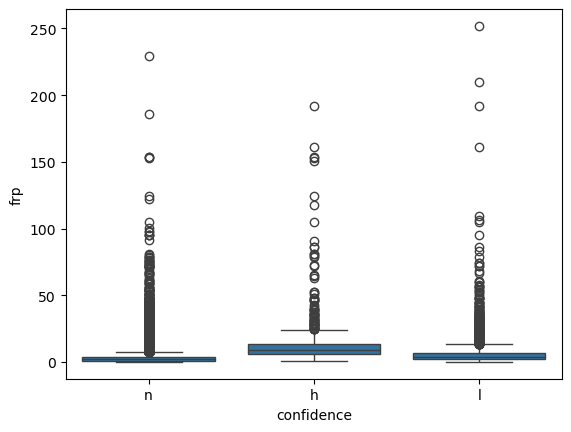

In [76]:
sns.boxplot(fire_df, y='frp', x='confidence')

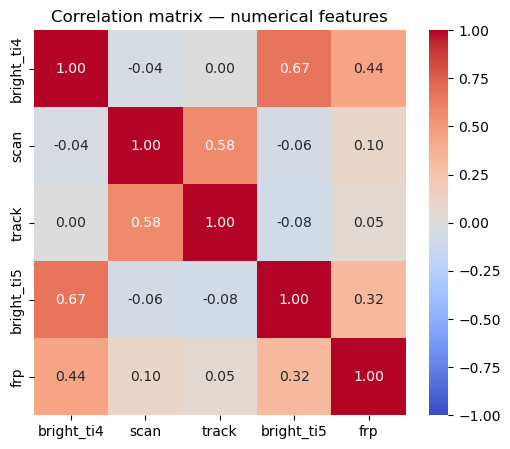

In [80]:
corr = fire_df[numerical_features].astype(float).corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix — numerical features")
plt.show()

In [8]:
output_base = os.path.join(output_folder, output_folders["fire"])
os.makedirs(output_base, exist_ok=True)
output_filepath = os.path.join(output_base, "fire.csv")

fire_df.to_csv(output_filepath)

print(f"Saved combined fire DF to: {output_filepath}")

Saved combined fire DF to: ./processed_data/fire_dataset/fire.csv


## Land Cover Dataset

A land cover code is a classification system used to categorize the physical and biophysical attributes of the Earth's surface, such as forests, grasslands, water, or built-up areas. These codes are used in mapping and geographic information systems (GIS) to standardize and describe different types of land cover, with popular systems including the Land Cover Classification System (LCCS) developed by the UN Food and Agriculture Organization (FAO). 

### Merging the Data

#### Algeria Data

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 386454 entries, 0 to 386453
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   ID        386454 non-null  int32   
 1   GRIDCODE  386454 non-null  int32   
 2   AREA      386454 non-null  float64 
 3   LCCCODE   386454 non-null  object  
 4   geometry  386454 non-null  geometry
dtypes: float64(1), geometry(1), int32(2), object(1)
memory usage: 11.8+ MB
None
   ID  GRIDCODE          AREA       LCCCODE  \
0   4       210  6.228187e+06  7001 // 8001   
1   2       210  6.242408e+06  7001 // 8001   
2   1       210  1.482995e+06  7001 // 8001   
3   8        50  4.590841e+08  21497-121340   
4  13       210  6.371533e+06  7001 // 8001   

                                            geometry  
0  POLYGON ((6.41528 37.08696, 6.43103 37.0855, 6...  
1  POLYGON ((7.18084 37.07917, 7.17998 37.08091, ...  
2  POLYGON ((7.37137 37.08194, 7.3709 37.08717, 7...  
3  POLYGON 

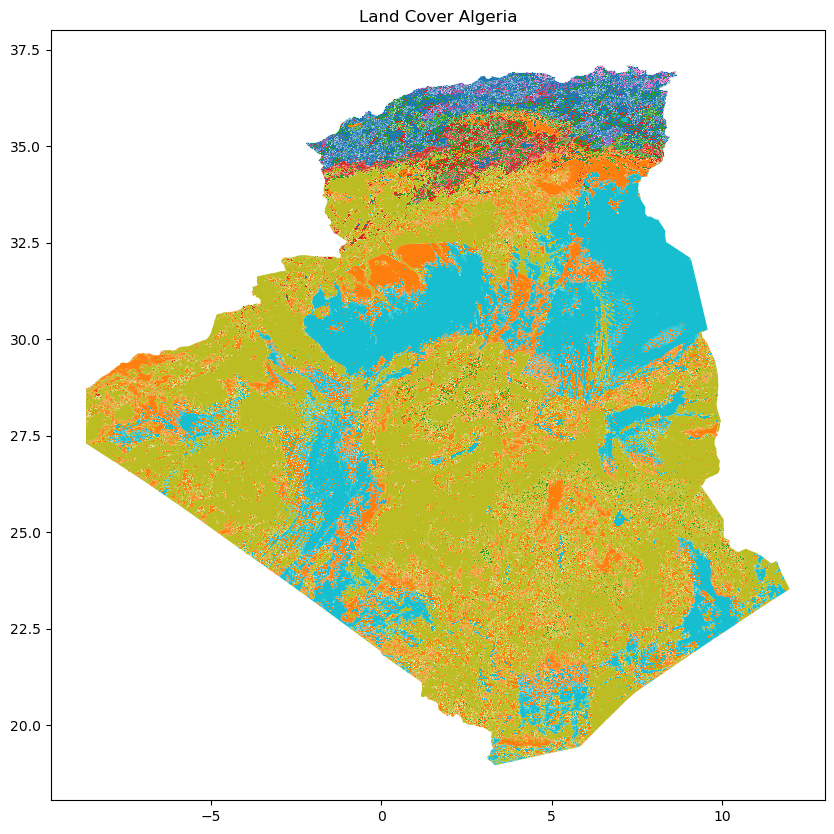

In [96]:
landcover_dz_filepath = os.path.join(data_folder, data_files["landcover_dz"])

# Read the shapefile into a GeoDataFrame
landcover_dz_gdf = geopandas.read_file(landcover_dz_filepath)

print(landcover_dz_gdf.info())

print(landcover_dz_gdf.head())
import matplotlib.pyplot as plt
landcover_dz_gdf.plot(column='LCCCODE', legend=False, figsize=(10, 10))
plt.title('Land Cover Algeria')

plt.show()

####  Tunisia Data


In [97]:
landcover_tn_filepath = os.path.join(data_folder, data_files["landcover_tn"])

# Read the shapefile into a GeoDataFrame
landcover_tn_gdf = geopandas.read_file(landcover_tn_filepath)

print(landcover_tn_gdf.info())

print(landcover_tn_gdf.head())


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 52059 entries, 0 to 52058
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   AREA_M2   52059 non-null  float64 
 1   ID        52059 non-null  int32   
 2   GRIDCODE  52059 non-null  int32   
 3   LCCCode   52059 non-null  object  
 4   geometry  52059 non-null  geometry
dtypes: float64(1), geometry(1), int32(2), object(1)
memory usage: 1.6+ MB
None
     AREA_M2  ID  GRIDCODE                  LCCCode  \
0  3110936.0   1       210             7001 // 8001   
1   982723.0   3        20              0003 / 0004   
2   151388.0   2        30             0004 // 0003   
3   151391.0   6       120  21454 // 21446 // 21450   
4   151391.0   4        70             21499-121340   

                                            geometry  
0  POLYGON ((8.89941 37.52083, 8.89923 37.52117, ...  
1  POLYGON ((8.94028 37.52361, 8.94028 37.52917, ...  
2  POLYGON ((8.94583 37.5347

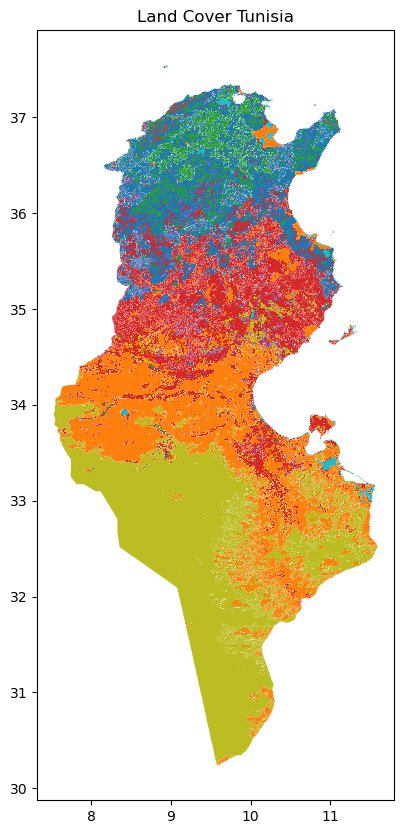

In [98]:
landcover_tn_gdf.plot(column='LCCCode', legend=False, figsize=(10, 10))
plt.title('Land Cover Tunisia')
plt.show()

#### Merging Landcover Data

In [99]:
# Renamed the columns because of name mismatch
landcover_tn_gdf = landcover_tn_gdf.rename(columns={'LCCCode': 'LCCCODE', 'AREA_M2': 'AREA'})

In [100]:
landcover_dz_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 386454 entries, 0 to 386453
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   ID        386454 non-null  int32   
 1   GRIDCODE  386454 non-null  int32   
 2   AREA      386454 non-null  float64 
 3   LCCCODE   386454 non-null  object  
 4   geometry  386454 non-null  geometry
dtypes: float64(1), geometry(1), int32(2), object(1)
memory usage: 11.8+ MB


In [101]:
def merge_shapefiles(dz_gdf, tn_gdf):
    # Ensure both shapefiles use the same CRS 
    if dz_gdf.crs != tn_gdf.crs:
        tn = tn.to_crs(dz_gdf.crs)

    # Concatenate the GeoDataFrames
    boundaries = geopandas.GeoDataFrame(pd.concat([dz_gdf, tn_gdf], ignore_index=True), crs=dz_gdf.crs)

    return boundaries


In [102]:
landcover_gdf = merge_shapefiles(landcover_dz_gdf, landcover_tn_gdf)
landcover_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 438513 entries, 0 to 438512
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   ID        438513 non-null  int32   
 1   GRIDCODE  438513 non-null  int32   
 2   AREA      438513 non-null  float64 
 3   LCCCODE   438513 non-null  object  
 4   geometry  438513 non-null  geometry
dtypes: float64(1), geometry(1), int32(2), object(1)
memory usage: 13.4+ MB


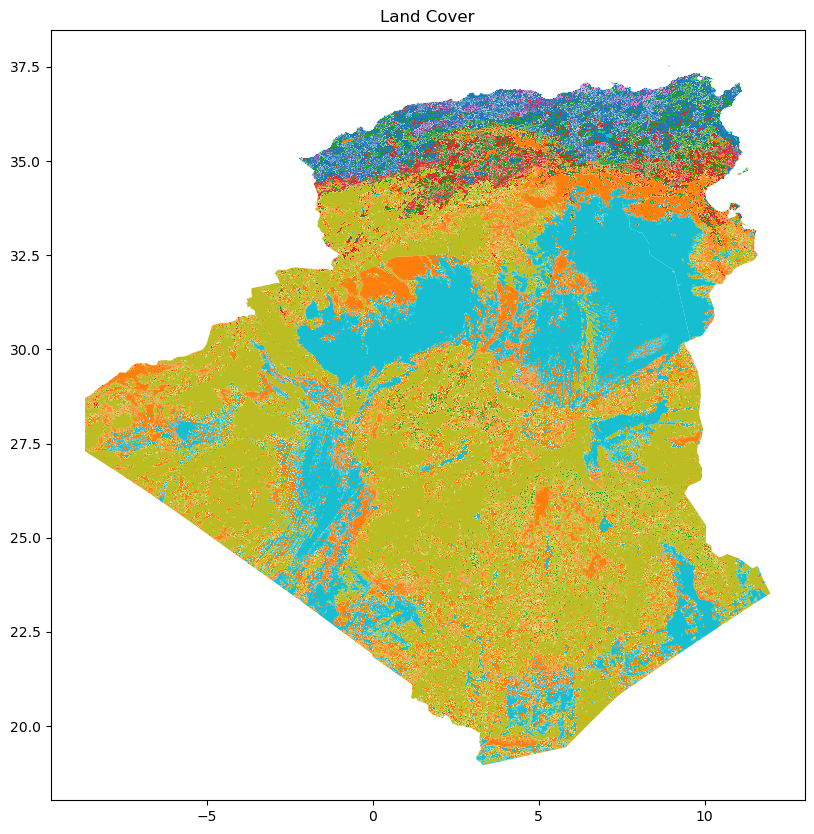

In [16]:
landcover_gdf.plot(column='LCCCODE', legend=False, figsize=(10, 10))
plt.title('Land Cover')
plt.show()

### EDA

In [105]:
landcover_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 438513 entries, 0 to 438512
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   ID        438513 non-null  int32   
 1   GRIDCODE  438513 non-null  int32   
 2   AREA      438513 non-null  float64 
 3   LCCCODE   438513 non-null  object  
 4   geometry  438513 non-null  geometry
dtypes: float64(1), geometry(1), int32(2), object(1)
memory usage: 13.4+ MB


In [110]:
landcover_gdf['LCCCODE'].nunique()

22

In [113]:
# install xlrd to read excel files

xls = pd.ExcelFile(r"./data/landcover_dz/globcover_LCCS_legend_africa.xls") 

lccs_legend_df = xls.parse(0) 
lccs_legend_df

LC  LPos  \
0                 9Mixed Class   1.0   
1                        Error   1.0   
2           0Dichotomous Phase   1.0   
3                 9Mixed Class   1.0   
4                          NaN   NaN   
5                 9Mixed Class   1.0   
6                          NaN   NaN   
7           0Dichotomous Phase   1.0   
8           0Dichotomous Phase   1.0   
9     1Consolidated Bare Areas   1.0   
10  2Unconsolidated Bare Areas   1.0   
11                       Error   1.0   
12                9Mixed Class   1.0   
13                9Mixed Class   1.0   
14                 5Grasslands   1.0   
15                9Mixed Class   1.0   
16                       Error   1.0   
17                9Mixed Class   1.0   
18                9Mixed Class   1.0   
19                       Error   1.0   
20                9Mixed Class   1.0   
21                9Mixed Class   1.0   
22                9Mixed Class   1.0   
23                9Mixed Class   1.0   
24                9Mixed Class   1.0   
25                9Mixed Class   1.0   
26                9Mixed Class   1.0   
27                9Mixed Class   1.0   
28                9Mixed Class   3.0   
29                       Error   1.0   
30                   2Woodland   2.0   
31                       Error   1.0   
32                9Mixed Class   2.0   
33                   2Woodland   2.0   
34                   2Woodland   2.0   
35                       Error   1.0   
36                       Error   1.0   
37                9Mixed Class   1.0   
38                9Mixed Class   1.0   
39                       Error   1.0   
40                9Mixed Class   1.0   
41                       Error   1.0   
42                9Mixed Class   1.0   
43                       Error   1.0   
44                9Mixed Class   1.0   
45          6Sparse Vegetation   1.0   
46          6Sparse Vegetation   1.0   

                                         LCCCode  LCCMode  \
0                           41653-R1 // 41653-R2      0.0   
1                                       41739-R1      0.0   
2                                           0007      0.0   
3   41521-R1 // 41521-R2 // 41597-R1 // 41597-R2      0.0   
4                                            NaN      NaN   
5   42347-R1 // 42347-R2 // 42349-R1 // 42349-R2      0.0   
6                                            NaN      NaN   
7                                           0010      0.0   
8                                           0011      0.0   
9                                           6001      0.0   
10                                          6004      0.0   
11                                          6020      0.0   
12                                  8005 // 8008      0.0   
13                                  7001 // 8001      0.0   
14                                         20038      0.0   
15              41638-60686-R2 // 41898-60686-R2      0.0   
16                                41724-60686-R1      0.0   
17                       11499 // 11500 // 30001      0.0   
18                                11491 // 11495      0.0   
19                                         11498      0.0   
20                                11490 // 11494      0.0   
21                                   0003 / 0004      0.0   
22                        0003 // 21453 // 21449      0.0   
23                                  0004 // 0003      0.0   
24                         21453 // 21449 / 0003      0.0   
25                                  21445 / 0003      0.0   
26                          21496 // 21497-15048      0.0   
27                  21496-121340 // 21497-129401      0.0   
28                      20797-3012 // 20809-6011      0.0   
29                                  21497-121340      0.0   
30                                    20132-3012      0.0   
31                                  21499-121340      0.0   
32                      20135-3012 // 20134-3012      0.0   
33                               

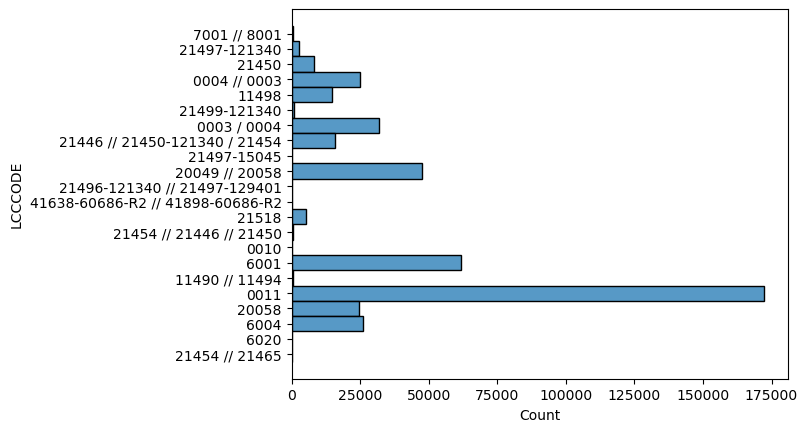

In [114]:
sns.histplot(landcover_gdf, y="LCCCODE")
plt.show()

## Climate Dataset

### Exploring the Data

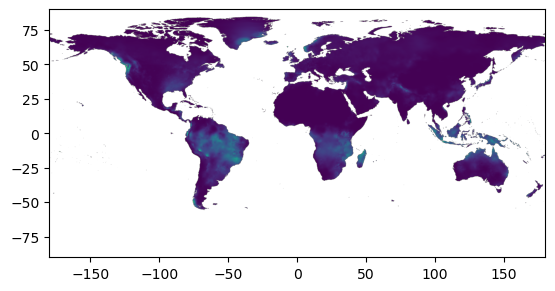

(1, 2160, 4320)


In [18]:
file = os.path.join(data_folder, data_files["climate_prec"], "wc2.1_cruts4.09_5m_prec_2020-01.tif")
src = rasterio.open(file)
show(src)

# Checking the number of bands
array = src.read()
print(array.shape)

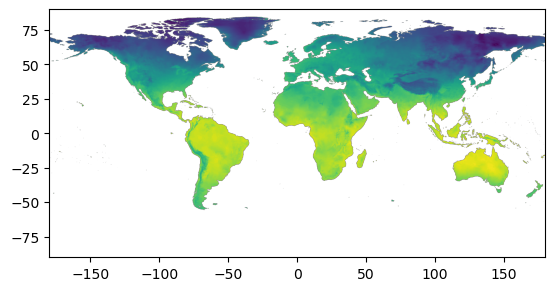

(1, 2160, 4320)


In [19]:
file = os.path.join(data_folder, data_files["climate_tmin"], "wc2.1_cruts4.09_5m_tmin_2020-01.tif")
src = rasterio.open(file)
show(src)

# Checking the number of bands
array = src.read()
print(array.shape)

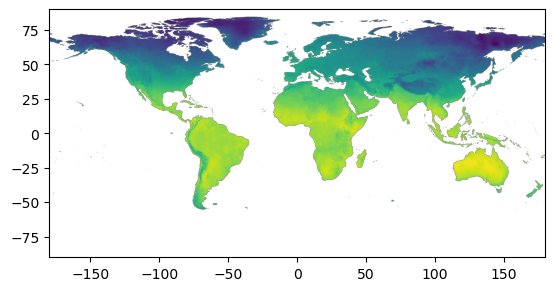

(1, 2160, 4320)


In [20]:
file = os.path.join(data_folder, data_files["climate_tmax"], "wc2.1_cruts4.09_5m_tmax_2020-01.tif")
src = rasterio.open(file)
show(src)

# Checking the number of bands
array = src.read()
print(array.shape)

### Loading and merging the boundaries of Algeria and Tunisia

In [1]:
def load_dz_tn_boundaries(dz_shapefile_path, tn_shapefile_path):
    dz = geopandas.read_file(dz_shapefile_path)
    tn = geopandas.read_file(tn_shapefile_path)

    # Ensure both shapefiles use the same CRS 
    if dz.crs != tn.crs:
        tn = tn.to_crs(dz.crs)

    # Concatenate the GeoDataFrames
    boundaries = geopandas.GeoDataFrame(pd.concat([dz, tn], ignore_index=True), crs=dz.crs)

    return boundaries

# Shapefile downloaded from https://gadm.org/

In [6]:
dz_boundaries_filepath = os.path.join(data_folder, data_files["dz_boundaries"])
tn_boundaries_filepath = os.path.join(data_folder, data_files["tn_boundaries"])

boundaries = load_dz_tn_boundaries(dz_boundaries_filepath, tn_boundaries_filepath)

##### Clipping to the ROI

In [10]:
def clip_instance(file, boundaries=boundaries):
    with rasterio.open(file) as src:
        # Clip raster with shapefile
        out_image, out_transform = mask(src, boundaries.geometry, crop=True)
        out_meta = src.meta.copy()
    
    # Update metadata
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    return out_image, out_meta

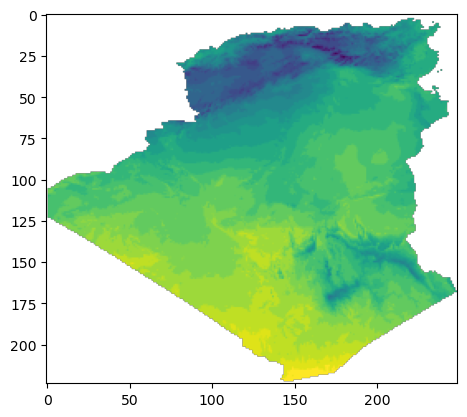

<Axes: >

In [24]:
# PoC
show(clip_instance(file)[0])

In [25]:
output_base = os.path.join(output_folder, output_folders["climate"])

for var in ["climate_prec", "climate_tmax", "climate_tmin"]:
    climate_folder = os.path.join(data_folder, data_files[var])

    for filename in os.listdir(climate_folder):
        if filename.endswith(".tif") and "2024" in filename:
            filepath = os.path.join(climate_folder, filename)
            try:
                # Clip raster
                clipped_image, clipped_meta = clip_instance(filepath, boundaries)

                # Save output
                save_path = os.path.join(output_base, var.split("_")[1])  # prec | tmax | tmin
                os.makedirs(save_path, exist_ok=True)

                output_filename = f"clipped_{filename}"
                output_filepath = os.path.join(save_path, output_filename)

                with rasterio.open(output_filepath, "w", **clipped_meta) as dest:
                    dest.write(clipped_image)

                print(f"Saved clipped raster to: {output_filepath}")

            except Exception as e:
                print(f"Error processing {filename}: {e}")

Saved clipped raster to: ./processed_data/climate_dataset/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-05.tif
Saved clipped raster to: ./processed_data/climate_dataset/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-04.tif
Saved clipped raster to: ./processed_data/climate_dataset/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-01.tif
Saved clipped raster to: ./processed_data/climate_dataset/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-03.tif
Saved clipped raster to: ./processed_data/climate_dataset/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-07.tif
Saved clipped raster to: ./processed_data/climate_dataset/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-09.tif
Saved clipped raster to: ./processed_data/climate_dataset/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-02.tif
Saved clipped raster to: ./processed_data/climate_dataset/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-10.tif
Saved clipped raster to: ./processed_data/climate_dataset/prec/clipped_wc2.1_cruts4.09_5m_prec_2024-11.tif
Saved clipped raster to: ./processed_

## Elevation Dataset

In [116]:
grid_path = os.path.join(data_folder, data_files["elevation"])  
with rasterio.open(grid_path) as src:
    print(src.driver)    
    print(src.width, src.height, src.shape)
    print(src.crs)
    print(src.bounds)
    arr = src.read(1) 
    print(arr.shape)

AIG
86400 33600 (33600, 86400)
EPSG:4326
BoundingBox(left=-180.00013888888893, bottom=-56.00013888888891, right=179.99986111111085, top=83.999861111111)
(33600, 86400)


In [125]:
img_elevation, meta_elevation = clip_instance(grid_path)

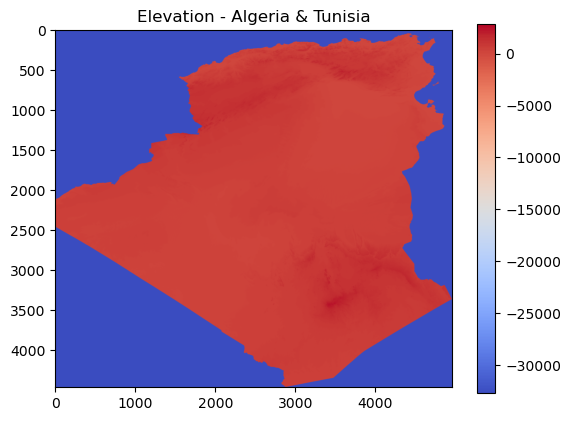

In [ ]:
plt.imshow(img_elevation[0], cmap='coolwarm')
plt.title("Elevation - Algeria & Tunisia")
plt.colorbar()
plt.show()

In [29]:
output_base = os.path.join(output_folder, output_folders["elevation"])
os.makedirs(output_base, exist_ok=True)
output_filepath = os.path.join(output_base, "Elevation_DZ_TN.tif")
with rasterio.open(output_filepath, "w", **meta_elevation) as dest:
    dest.write(img_elevation)

print(f"Saved clipped raster to: {output_filepath}")

Saved clipped raster to: ./processed_data/elevation_dataset/Elevation_DZ_TN.tif


## Soil Dataset

In [58]:
soil_filepath = os.path.join(data_folder, data_files["soil"])
with rasterio.open(soil_filepath) as src:
    print(src.driver)    
    print(src.width, src.height, src.shape)
    print(src.crs)
    print(src.bounds)
    arr = src.read(1) 
    print(arr.shape)

RasterioIOError: ./data/HWSD2_RASTER/HWSD2.bil: No such file or directory

In [8]:
import numpy as np

unique_ids = np.unique(arr)
print(unique_ids[:10], len(unique_ids))

[ 2 36 37 38 39 41 44 45 47 50] 29470


In [11]:
img, meta = clip_instance(soil_filepath)

In [12]:
print(img)

[[[65535 65535 65535 ... 65535 65535 65535]
  [65535 65535 65535 ... 65535 65535 65535]
  [65535 65535 65535 ... 65535 65535 65535]
  ...
  [65535 65535 65535 ... 65535 65535 65535]
  [65535 65535 65535 ... 65535 65535 65535]
  [65535 65535 65535 ... 65535 65535 65535]]]


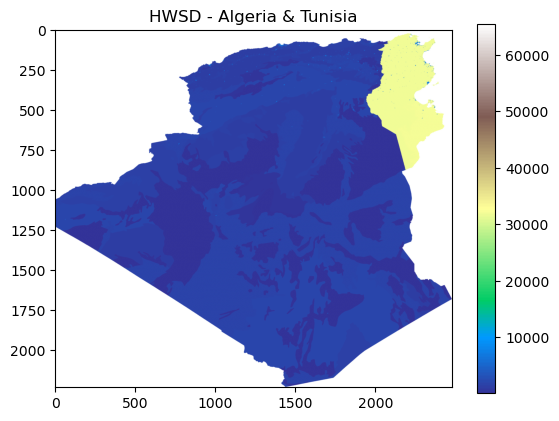

In [34]:
plt.imshow(img[0], cmap='terrain')
plt.title("HWSD - Algeria & Tunisia")
plt.colorbar()
plt.show()

#### Reading the Database

Step1:
- `sudo apt install mdbtools`

Step2:
- `mdb-export HWSD2.mdb HWSD2_LAYERS > HWSD2_LAYERS.csv`

https://openknowledge.fao.org/server/api/core/bitstreams/149f1562-bf6a-439f-9d3a-eb93940f39cf/content

In [14]:
layers_df = pd.read_csv('./data/HWSD2_DB/HWSD2_LAYERS.csv')
layers_df = layers_df[layers_df['LAYER'] == 'D1']
layers_df['LAYER'].value_counts()

/tmp/ipykernel_23100/1912304175.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  layers_df = pd.read_csv('./data/HWSD2_DB/HWSD2_LAYERS.csv')


LAYER
D1    58405
Name: count, dtype: int64

In [15]:
layers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58405 entries, 666 to 408828
Data columns (total 48 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              58405 non-null  int64  
 1   HWSD2_SMU_ID    58405 non-null  int64  
 2   NSC_MU_SOURCE1  15554 non-null  object 
 3   NSC_MU_SOURCE2  15549 non-null  object 
 4   WISE30s_SMU_ID  58405 non-null  object 
 5   HWSD1_SMU_ID    58405 non-null  int64  
 6   COVERAGE        58405 non-null  int64  
 7   SEQUENCE        58405 non-null  int64  
 8   SHARE           58405 non-null  int64  
 9   NSC             0 non-null      float64
 10  WRB_PHASES      58395 non-null  object 
 11  WRB4            56657 non-null  object 
 12  WRB2            58405 non-null  object 
 13  FAO90           58405 non-null  object 
 14  ROOT_DEPTH      58405 non-null  float64
 15  PHASE1          19485 non-null  float64
 16  PHASE2          17705 non-null  float64
 17  ROOTS           10063 non-null  f

In [16]:
layers_df = layers_df[layers_df["HWSD2_SMU_ID"].isin(unique_ids)]

In [17]:
layers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58218 entries, 666 to 408828
Data columns (total 48 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              58218 non-null  int64  
 1   HWSD2_SMU_ID    58218 non-null  int64  
 2   NSC_MU_SOURCE1  15540 non-null  object 
 3   NSC_MU_SOURCE2  15536 non-null  object 
 4   WISE30s_SMU_ID  58218 non-null  object 
 5   HWSD1_SMU_ID    58218 non-null  int64  
 6   COVERAGE        58218 non-null  int64  
 7   SEQUENCE        58218 non-null  int64  
 8   SHARE           58218 non-null  int64  
 9   NSC             0 non-null      float64
 10  WRB_PHASES      58208 non-null  object 
 11  WRB4            56472 non-null  object 
 12  WRB2            58218 non-null  object 
 13  FAO90           58218 non-null  object 
 14  ROOT_DEPTH      58218 non-null  float64
 15  PHASE1          19458 non-null  float64
 16  PHASE2          17685 non-null  float64
 17  ROOTS           10063 non-null  f

In [18]:
layers_df.groupby('HWSD2_SMU_ID')['SHARE'].value_counts()

HWSD2_SMU_ID  SHARE
2             10       2
              30       1
              50       1
36            100      1
37            30       1
                      ..
49826         100      1
49827         100      1
49828         100      1
49829         100      1
49830         100      1
Name: count, Length: 51559, dtype: int64

In [19]:
unique_smu_ids = np.unique(layers_df['HWSD2_SMU_ID'])
print(unique_smu_ids[:10])
print(unique_ids[:10])

print(all([raster_id in unique_smu_ids for raster_id in unique_ids]))

[ 2 36 37 38 39 41 44 45 47 50]
[ 2 36 37 38 39 41 44 45 47 50]
False


In [55]:
features_oi = [
    "COARSE", "SAND", "SILT", "CLAY", "TEXTURE_USDA", "TEXTURE_SOTER",
    "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER", "TOTAL_N", "CN_RATIO",
    "CEC_SOIL", "CEC_CLAY", "CEC_EFF", "TEB", "BSAT", "ALUM_SAT", "ESP",
    "TCARBON_EQ", "GYPSUM", "ELEC_COND"
]

layers_df[features_oi].info()

<class 'pandas.core.frame.DataFrame'>
Index: 58218 entries, 666 to 408828
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   COARSE         58218 non-null  int64  
 1   SAND           58218 non-null  int64  
 2   SILT           58218 non-null  int64  
 3   CLAY           58218 non-null  int64  
 4   TEXTURE_USDA   56931 non-null  float64
 5   TEXTURE_SOTER  58218 non-null  object 
 6   BULK           58218 non-null  float64
 7   REF_BULK       56931 non-null  float64
 8   ORG_CARBON     57548 non-null  float64
 9   PH_WATER       58218 non-null  float64
 10  TOTAL_N        58218 non-null  float64
 11  CN_RATIO       58218 non-null  int64  
 12  CEC_SOIL       58218 non-null  int64  
 13  CEC_CLAY       58218 non-null  int64  
 14  CEC_EFF        58218 non-null  int64  
 15  TEB            58218 non-null  int64  
 16  BSAT           58218 non-null  int64  
 17  ALUM_SAT       58218 non-null  int64  
 18  ESP     

In [ ]:
layers_df['TEXTURE_SOTER'].value_counts()

TEXTURE_SOTER
M    43062
C     7996
F     5849
-     1287
V       24
Name: count, dtype: int64

In [22]:
layers_df['TEXTURE_USDA'].value_counts()

TEXTURE_USDA
9.0     21849
11.0    13342
5.0      8536
3.0      3608
12.0     3229
10.0     3168
7.0      2974
8.0       194
4.0        31
Name: count, dtype: int64

In [56]:
features_oi_cat = [
    "TEXTURE_USDA", "TEXTURE_SOTER",
]

features_oi_num = features_oi

for cat_feature in features_oi_cat:
    features_oi_num.remove(cat_feature)

In [24]:
def weighted_avg(group):
    weights = group['SHARE'] / 100.0  # Convert percent to fraction
    result = {}
    for feature in features_oi_num:
        values = group[feature]
        if np.issubdtype(values.dtype, np.number):
            result[feature] = np.average(values, weights=weights) if weights.sum() > 0 else np.nan
        else:
            result[feature] = np.nan  # skip non-numeric fields
    return pd.Series(result)

# Apply the function to each group
soil_df = layers_df.groupby('HWSD2_SMU_ID').apply(weighted_avg).reset_index()

/tmp/ipykernel_23100/1242100999.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  soil_df = layers_df.groupby('HWSD2_SMU_ID').apply(weighted_avg).reset_index()


In [25]:
def most_common_texture(group, column):
    counts = group[column].value_counts()
    return counts.index[0] if not counts.empty else np.nan


soil_df['TEXTURE_USDA'] = layers_df.groupby('HWSD2_SMU_ID').apply(
    lambda g: most_common_texture(g, 'TEXTURE_USDA')
).reset_index(drop=True)

soil_df['TEXTURE_SOTER'] = layers_df.groupby('HWSD2_SMU_ID').apply(
    lambda g: most_common_texture(g, 'TEXTURE_SOTER')
).reset_index(drop=True)

/tmp/ipykernel_23100/1330696623.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  soil_df['TEXTURE_USDA'] = layers_df.groupby('HWSD2_SMU_ID').apply(
/tmp/ipykernel_23100/1330696623.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  soil_df['TEXTURE_SOTER'] = layers_df.groupby('HWSD2_SMU_ID').apply(


In [26]:
soil_df.head()

HWSD2_SMU_ID  COARSE  SAND  SILT  CLAY   BULK  REF_BULK  ORG_CARBON  \
0             2    15.7  55.2  22.6  22.2  1.384     1.746      1.4977   
1            36    -4.0  -4.0  -4.0  -4.0 -4.000       NaN     -4.0000   
2            37     4.0  54.1  14.0  31.9  1.357     1.781      1.5601   
3            38    14.4  45.2  21.0  33.8  1.316     1.870      2.1106   
4            39     4.9  40.9  20.9  38.2  1.264     1.922      1.8535   

   PH_WATER  TOTAL_N  ...  CEC_EFF  TEB  BSAT  ALUM_SAT  ESP  TCARBON_EQ  \
0      5.77    1.099  ...      7.9  6.4  60.2      13.8  2.1         0.0   
1     -4.00   -4.000  ...     -4.0 -4.0  -4.0      -4.0 -4.0        -4.0   
2      5.02    1.386  ...      4.5  3.8  32.8      15.1  1.6         0.0   
3      5.30    1.588  ...      6.6  5.4  36.2      14.0  1.6         0.0   
4      4.87    1.674  ...      6.0  4.4  28.9      38.8  1.3         0.0   

   GYPSUM  ELEC_COND  TEXTURE_USDA  TEXTURE_SOTER  
0    0.06        0.5          10.0              M  
1   -4.00       -4.0           NaN              -  
2    0.03        0.0          12.0              C  
3    0.64        0.4           3.0              M  
4    0.00        0.3           3.0              F  

[5 rows x 23 columns]

In [57]:
soil_df[features_oi_num].describe()

COARSE          SAND          SILT          CLAY          BULK  \
count  29469.000000  29469.000000  29469.000000  29469.000000  29469.000000   
mean      11.030545     44.485551     30.840640     21.623903      1.204806   
std        7.440579     15.211129     10.743064      9.369439      1.004594   
min       -9.000000     -9.000000     -9.000000     -9.000000     -9.000000   
25%        5.000000     36.000000     25.000000     16.150000      1.290000   
50%       10.000000     43.000000     32.000000     20.000000      1.380000   
75%       16.000000     53.000000     37.000000     27.000000      1.449000   
max       49.000000     94.000000     62.000000     65.000000      1.760000   

           REF_BULK    ORG_CARBON      PH_WATER       TOTAL_N      CN_RATIO  \
count  28185.000000  28799.000000  29469.000000  29469.000000  29469.000000   
mean       1.720392      2.316764      6.536115      1.541793     11.098905   
std        0.132890      4.190027      2.041065      1.995006      3.551078   
min        0.970000     -9.000000     -9.000000     -9.000000     -9.000000   
25%        1.654000      0.727000      6.000000      0.874000      9.900000   
50%        1.720000      1.364000      6.700000      1.216000     11.000000   
75%        1.810000      2.258000      7.856000      1.791500     12.100000   
max        2.090000     49.680000      9.000000     23.480000     29.000000   

           CEC_SOIL      CEC_CLAY       CEC_EFF           TEB          BSAT  \
count  29469.000000  29469.000000  29469.000000  29469.000000  29469.000000   
mean      17.303200     49.681979     22.984963     21.498871     77.787150   
std       10.711825     18.445460     13.793830     14.498542     23.449095   
min       -9.000000     -9.000000     -9.000000     -9.000000     -9.000000   
25%       12.440000     37.600000     13.500000     10.000000     66.600000   
50%       16.000000     50.200000     21.000000     18.700000     83.100000   
75%       20.000000     63.000000     32.000000     32.000000     97.700000   
max      105.000000    120.600000    143.000000    143.000000    100.000000   

           ALUM_SAT           ESP    TCARBON_EQ        GYPSUM     ELEC_COND  
count  29469.000000  29469.000000  29469.000000  29469.000000  29469.000000  
mean       3.798457      3.133700      5.284684      0.993201      0.953092  
std        8.243327      5.681201      7.421807      3.153699      1.804916  
min       -9.000000     -9.000000     -9.000000     -9.000000     -9.000000  
25%        0.000000      1.300000      0.000000      0.200000      0.600000  
50%        0.000000      2.000000      1.580000      0.420000      1.000000  
75%        3.300000      3.000000      9.630000      1.600000      1.000000  
max       85.000000     73.000000     31.299999     57.599998     32.000000

[65535 65535 65535 ... 65535 65535 65535]
Rendering column: COARSE


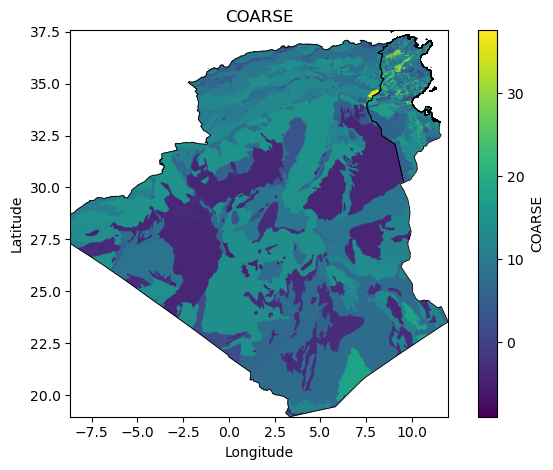

Rendering column: SAND


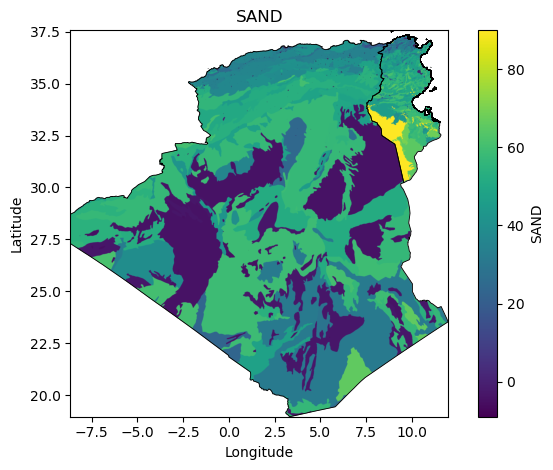

Rendering column: SILT


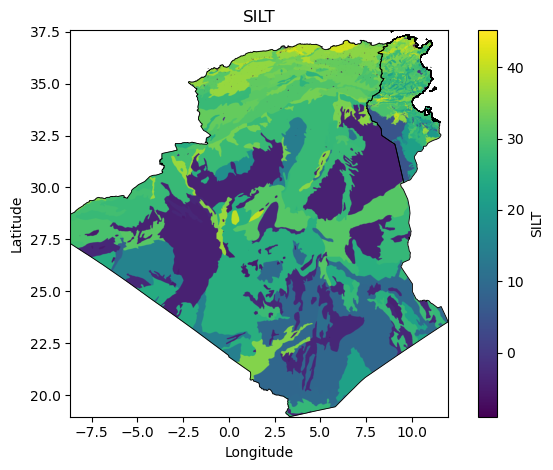

Rendering column: CLAY


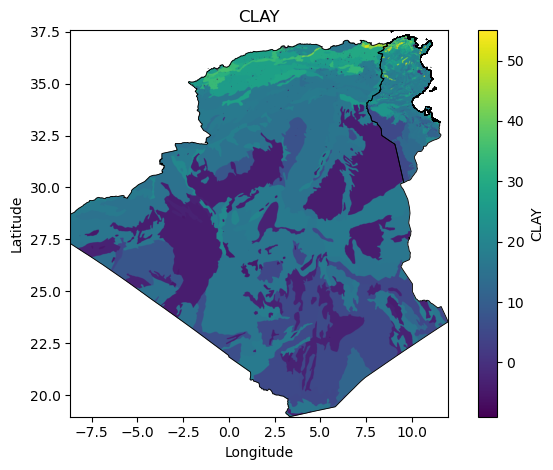

Rendering column: BULK


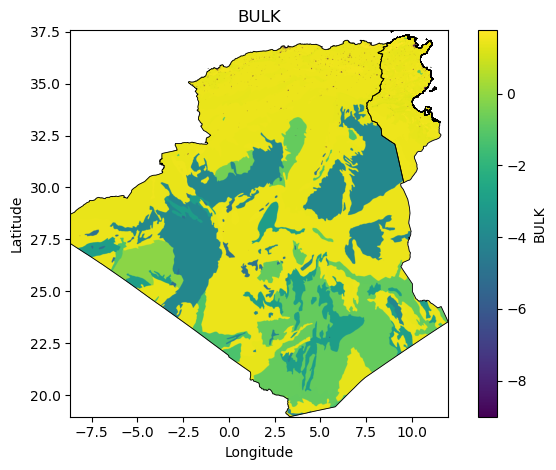

Rendering column: REF_BULK


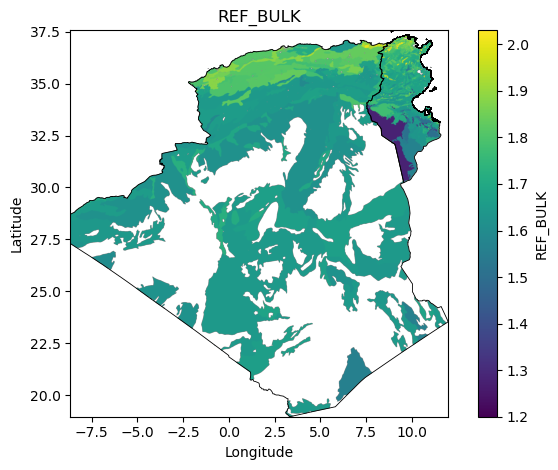

Rendering column: ORG_CARBON


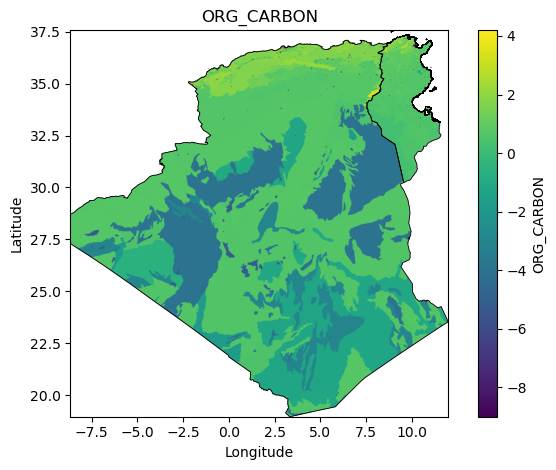

Rendering column: PH_WATER


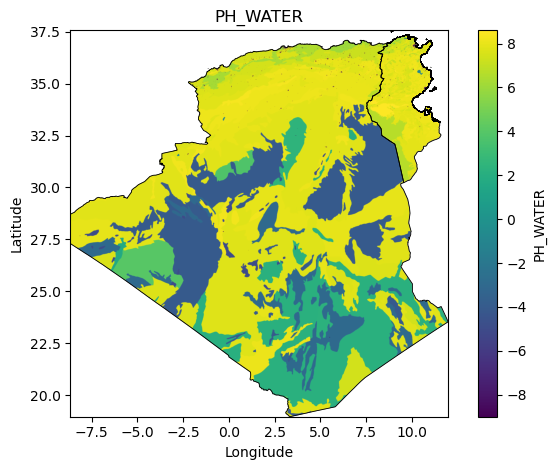

Rendering column: TOTAL_N


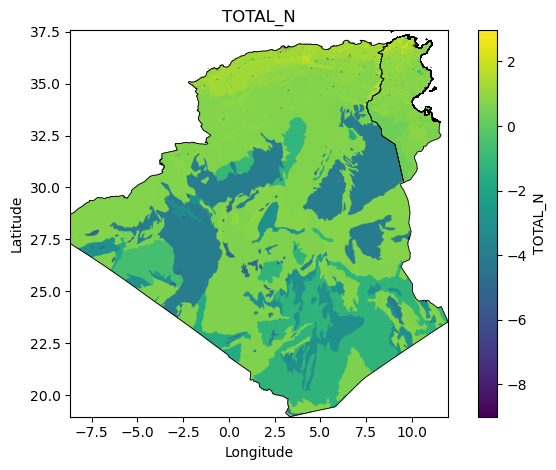

Rendering column: CN_RATIO


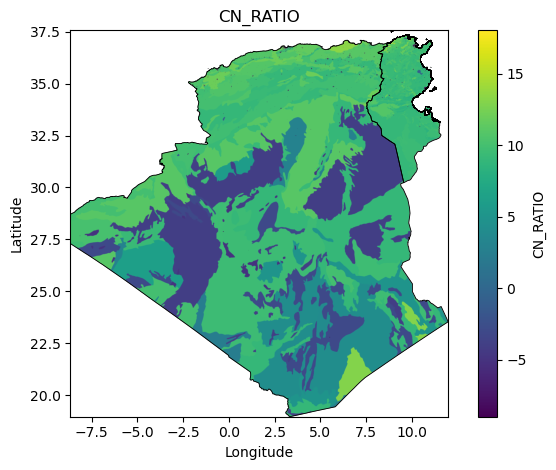

Rendering column: CEC_SOIL


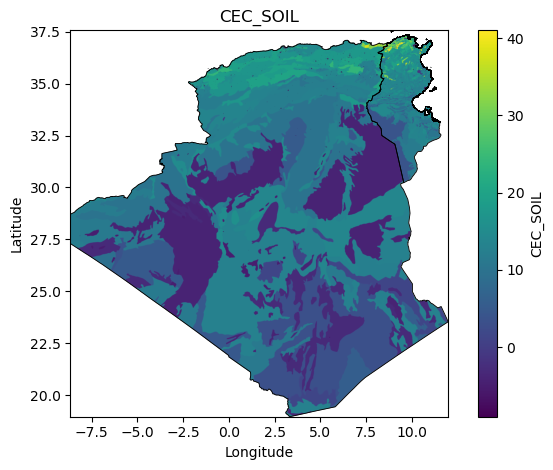

Rendering column: CEC_CLAY


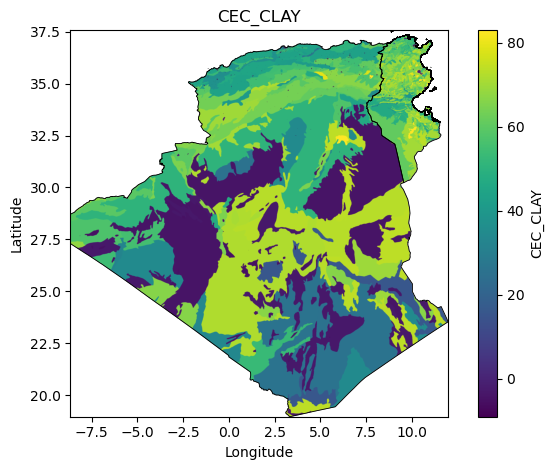

Rendering column: CEC_EFF


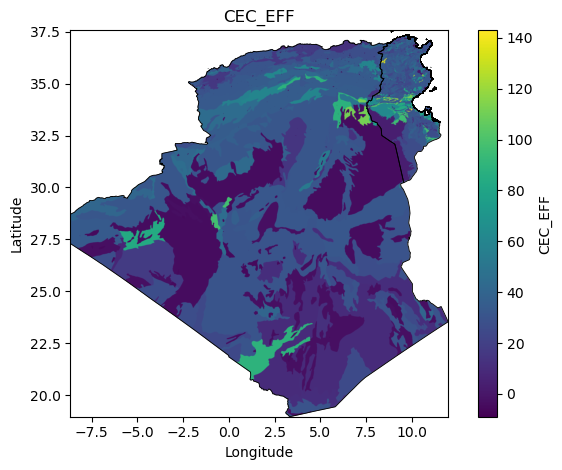

Rendering column: TEB


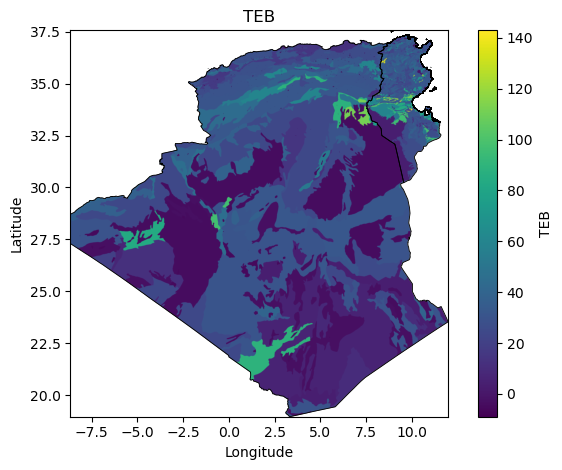

Rendering column: BSAT


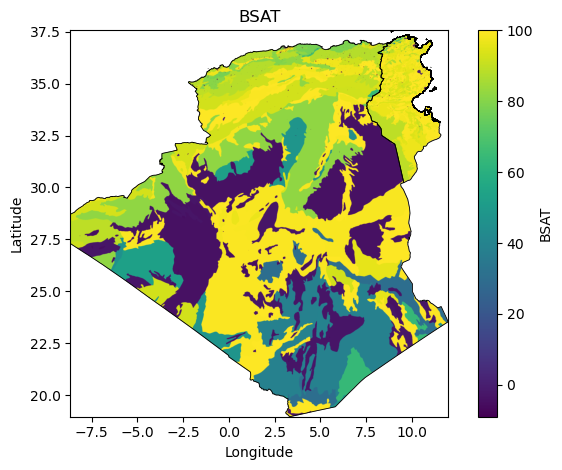

Rendering column: ALUM_SAT


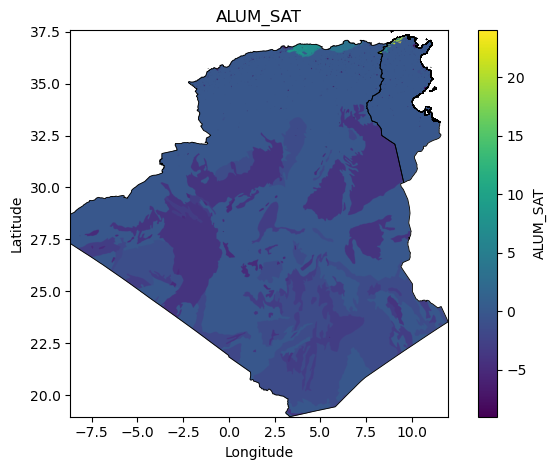

Rendering column: ESP


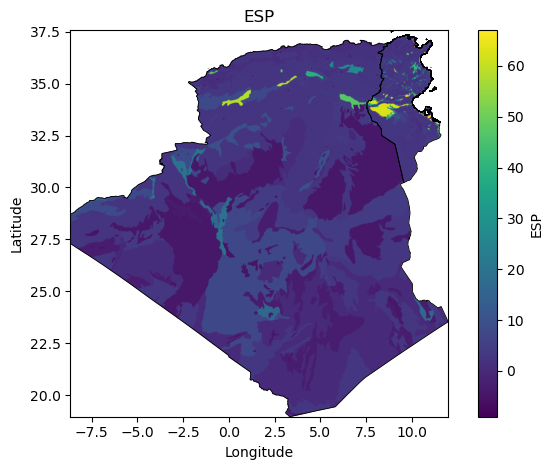

Rendering column: TCARBON_EQ


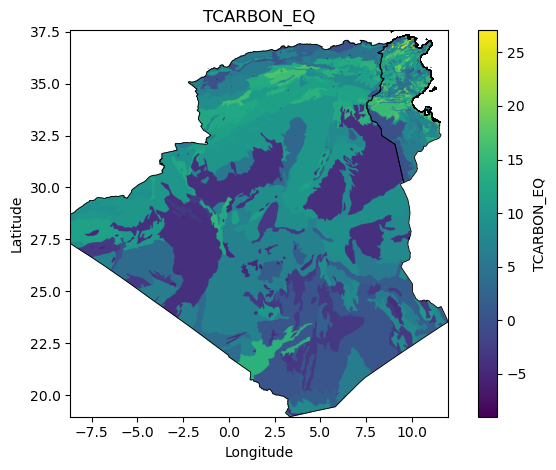

Rendering column: GYPSUM


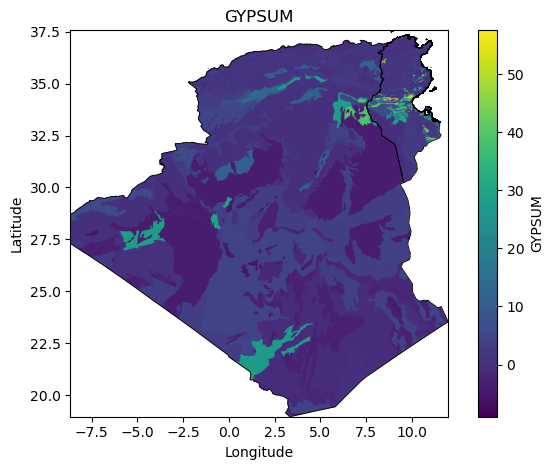

Rendering column: ELEC_COND


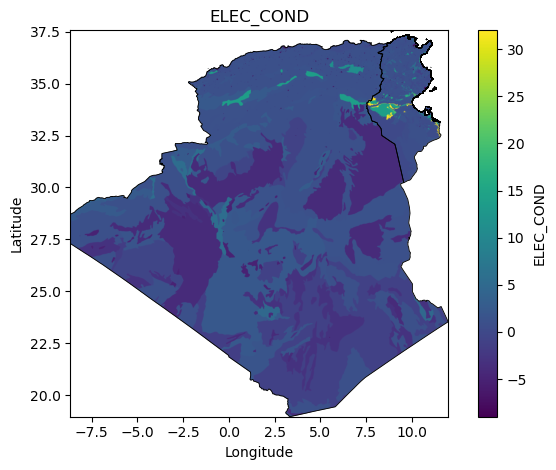

Rendering column: TEXTURE_USDA


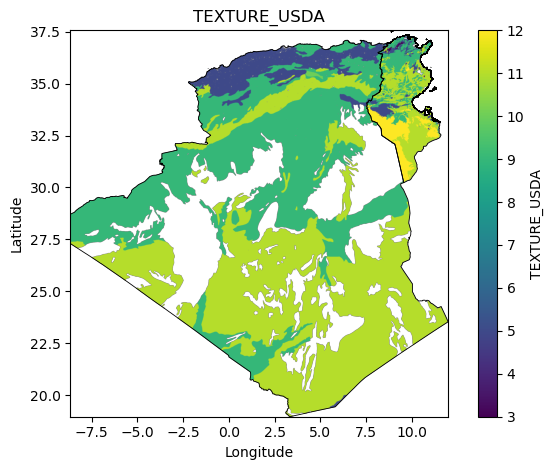

Rendering column: TEXTURE_SOTER


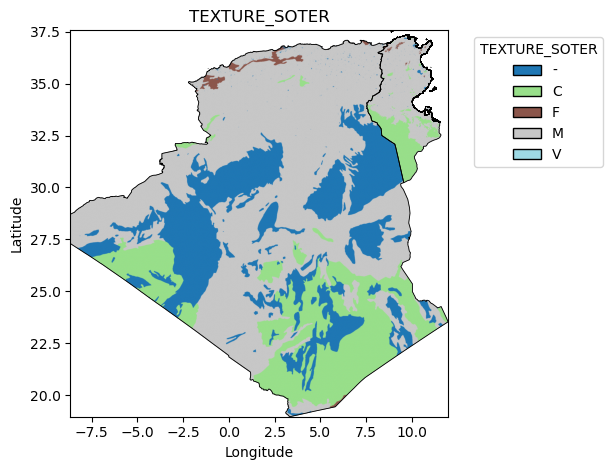

Saved soil attribute plots to ./processed_data/soil_dataset


In [63]:
# Visualize all soil_df columns projected into the clipped HWSD raster image (img, meta)

import matplotlib.colors as mcolors

# raster dims and flattened SMU ids
h, w = img.shape[1], img.shape[2]
flat_ids = img[0].ravel()

print(flat_ids)

# columns to visualize (skip the key id column if present)
id_col = 'HWSD2_SMU_ID'
cols = [c for c in soil_df.columns if c != id_col]

for col in cols:
    try:
        print(f"Rendering column: {col}")
        series = soil_df.set_index(id_col)[col]

        # numeric vs categorical
        if np.issubdtype(series.dtype, np.number):
            mapped = pd.Series(flat_ids).map(series)  # numeric, NaN where missing
            arr = mapped.values.reshape((h, w))

            # get bounds & extent
            minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, meta['transform'])

            # plt.figure(figsize=(10, 8))
            im = plt.imshow(arr, cmap='viridis', extent=(minx, maxx, miny, maxy))
            if 'boundaries' in globals():
                boundaries.plot(ax=plt.gca(), facecolor='none', edgecolor='k', linewidth=0.6)
            plt.title(f"{col}")
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")
            cbar = plt.colorbar(im)
            cbar.set_label(col)
            plt.tight_layout()

            plt.show()

        else:
            # categorical: map categories -> integers and display discrete colormap + legend
            cats = pd.Categorical(soil_df[col].astype(str))  # convert to str to avoid issues
            cat_map = pd.Series(cats.codes, index=soil_df[id_col].astype(int))
            mapped = pd.Series(flat_ids).map(cat_map)
            arr = mapped.values.reshape((h, w))

            # build colormap
            uniques = np.unique(cats.categories)
            n = len(uniques)
            cmap = plt.get_cmap('tab20', n)
            norm = mcolors.BoundaryNorm(np.arange(-0.5, n + 0.5, 1), cmap.N)

            minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, meta['transform'])

            # plt.figure(figsize=(10, 8))
            im = plt.imshow(arr, cmap=cmap, norm=norm, extent=(minx, maxx, miny, maxy))
            if 'boundaries' in globals():
                boundaries.plot(ax=plt.gca(), facecolor='none', edgecolor='k', linewidth=0.6)
            plt.title(f"{col}")
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")

            # legend: show mapping of colors -> categories
            # create custom legend patches
            from matplotlib.patches import Patch
            patches = []
            for i, label in enumerate(uniques):
                patches.append(Patch(facecolor=cmap(i), edgecolor='k', label=label))
            plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title=col)
            plt.tight_layout()

            plt.show()

    except Exception as e:
        print(f"Failed to render {col}: {e}")

print(f"Saved soil attribute plots to {out_base}")
# ...existing code...